<a href="https://colab.research.google.com/github/SamGrievo/Time-Series-Forecasting/blob/main/Many_to_one_BiTC_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp

import torch
import sklearn.metrics as skm
from torch.autograd import Variable
import time

In [ ]:
df = pd.read_csv('/content/Gemini_BTCUSD_2022_1min.csv')
df = df[180000:]

In [ ]:
df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
180000,1.640000e+12,06/01/2022 23:40,BTCUSD,43209.01,43230.76,43209.00,43217.80,0.015303
180001,1.640000e+12,06/01/2022 23:39,BTCUSD,43206.94,43220.41,43206.94,43209.01,0.059598
180002,1.640000e+12,06/01/2022 23:38,BTCUSD,43165.00,43210.26,43165.00,43206.94,1.409625
180003,1.640000e+12,06/01/2022 23:37,BTCUSD,43165.00,43165.00,43162.08,43165.00,0.657501
180004,1.640000e+12,06/01/2022 23:36,BTCUSD,43163.00,43165.00,43162.08,43165.00,0.177984


In [ ]:
bi_df = df.dropna()
bi_df = bi_df.sort_values(by="Date").reset_index(drop=True)
index = bi_df.Date
bi_data = bi_df.set_index(index)

In [ ]:
bi_data.head()


,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,,
01/01/2022 00:00,1.640000e+12,01/01/2022 00:00,BTCUSD,46220.00,46239.39,46219.86,46224.93,5.613981
01/01/2022 00:01,1.640000e+12,01/01/2022 00:01,BTCUSD,46224.93,46309.63,46214.07,46309.63,1.802484
01/01/2022 00:02,1.640000e+12,01/01/2022 00:02,BTCUSD,46309.63,46386.21,46297.08,46378.34,2.796398
01/01/2022 00:03,1.640000e+12,01/01/2022 00:03,BTCUSD,46378.34,46386.21,46316.82,46347.92,0.066140
01/01/2022 00:04,1.640000e+12,01/01/2022 00:04,BTCUSD,46347.92,46366.69,46347.66,46347.67,0.038852


In [ ]:
bi_data = bi_data.drop(columns=['Date','Symbol','Unix Timestamp','Volume'])


In [ ]:
bi_data.head()

,Open,High,Low,Close
Date,,,,
01/01/2022 00:00,46220.00,46239.39,46219.86,46224.93
01/01/2022 00:01,46224.93,46309.63,46214.07,46309.63
01/01/2022 00:02,46309.63,46386.21,46297.08,46378.34
01/01/2022 00:03,46378.34,46386.21,46316.82,46347.92
01/01/2022 00:04,46347.92,46366.69,46347.66,46347.67


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1f7175d90>,
      dtype=object)

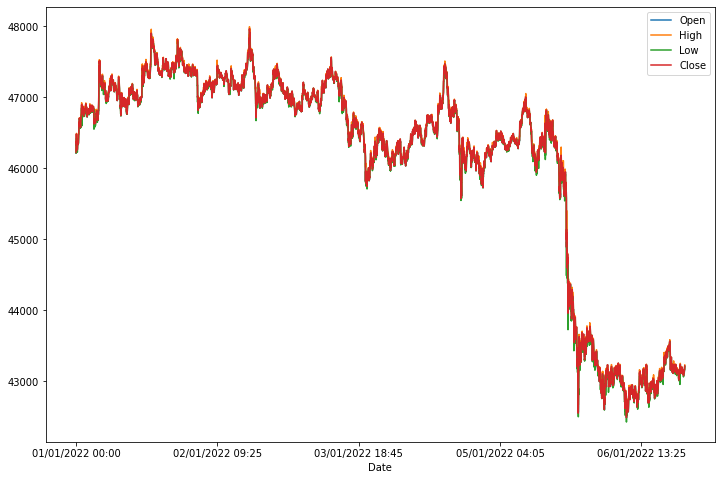

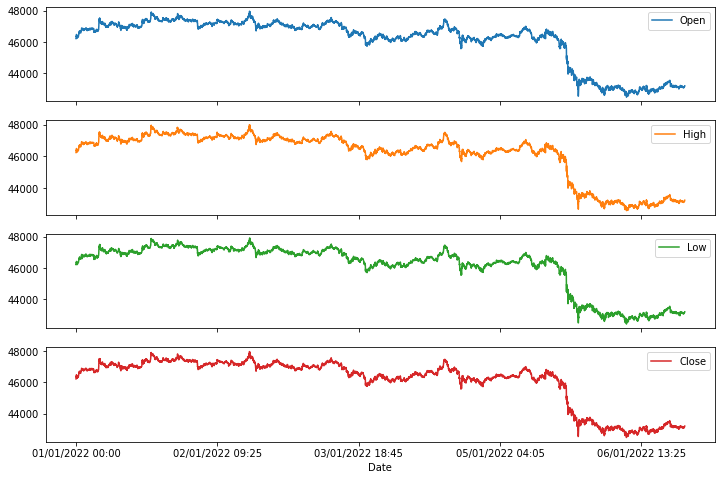

In [ ]:
bi_data.plot(figsize=(12,8))
bi_data.plot(subplots=True, figsize = (12,8))


In [ ]:

def custom_data_prep(data, window):
    x = []
    y = []

    for i in range(len(data)-window-1):
        _x = data[i:(i+window)]
        _y = data[i+window]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)



In [ ]:
scaler = skp.MinMaxScaler()
x_vals_scaled = scaler.fit_transform(bi_data.values)
#window size of a week
window = 24

x, y = custom_data_prep(x_vals_scaled, window)
y = y[:,3]
y=np.array(y)[:,np.newaxis]
y.shape

(8591, 1)

In [ ]:

train_size = int(len(y) * 0.85)
val_size = int(train_size+(len(y)*0.10))
test_size = int(val_size+(len(y)*0.10))

print(train_size,val_size,test_size)
train_x = Variable(torch.Tensor(np.array(x[0:train_size])))

train_y = Variable(torch.Tensor(np.array(y[0:train_size])))


train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_size)

data_batch, target_batch = next(iter(trainloader))
print(data_batch.size())
print(target_batch.size())
print('Training Window:', data_batch[0], data_batch.size(0))
print('Target:', target_batch[0])


val_x = Variable(torch.Tensor(np.array(x[train_size+1:val_size])))
val_y = Variable(torch.Tensor(np.array(y[train_size+1:val_size])))



val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=val_size)

val_data_batch, val_target_batch = next(iter(valloader))
print(val_data_batch.size())
print(val_target_batch.size())
print('Training Window:', val_data_batch[0])
print('Target:', val_target_batch[0])

test_x = Variable(torch.Tensor(np.array(x[val_size+1:test_size])))
test_y = Variable(torch.Tensor(np.array(y[val_size+1:test_size])))



test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_size)

test_data_batch, test_target_batch = next(iter(testloader))
print('test',test_data_batch.size())
print('test',test_target_batch.size())
print('Training Window:', test_data_batch[1],)
print('Target:', test_target_batch[1])

7302 8161 9020
torch.Size([7302, 24, 4])
torch.Size([7302, 1])
Training Window: tensor([[0.6811, 0.6757, 0.6911, 0.6820],
        [0.6820, 0.6887, 0.6900, 0.6975],
        [0.6975, 0.7028, 0.7051, 0.7100],
        [0.7100, 0.7028, 0.7087, 0.7044],
        [0.7044, 0.6992, 0.7143, 0.7044],
        [0.7044, 0.7075, 0.7093, 0.7160],
        [0.7160, 0.7220, 0.7260, 0.7296],
        [0.7296, 0.7227, 0.7288, 0.7190],
        [0.7190, 0.7105, 0.7205, 0.7112],
        [0.7112, 0.7042, 0.7144, 0.7045],
        [0.7045, 0.7005, 0.7140, 0.7082],
        [0.7082, 0.7006, 0.7034, 0.6965],
        [0.6965, 0.6877, 0.6996, 0.6910],
        [0.6910, 0.6971, 0.7010, 0.7015],
        [0.7015, 0.6930, 0.7067, 0.7005],
        [0.7005, 0.6919, 0.7043, 0.6988],
        [0.6988, 0.6901, 0.7073, 0.6978],
        [0.6978, 0.6890, 0.7008, 0.6908],
        [0.6908, 0.6820, 0.6979, 0.6885],
        [0.6885, 0.6820, 0.6927, 0.6909],
        [0.6909, 0.6874, 0.7008, 0.6939],
        [0.6939, 0.6971, 0.7005, 0.703

train set for error function 

In [ ]:
class LSTM(torch.nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        #num_classes = output dimension, num_layers = amount of LSTM layers stacked, input_size = input data dimension (window size), hidden_size = hidden neurons per layer.
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = window
        #PyTorch LSTM module
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        #PyTorch linear layer for output
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    #forward pass of cell and hidden state according to PyTorch documentation
    def forward(self, x):
      #hidden state output
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        #cell output
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        
        
        out = self.fc(h_out[0])
        
        return out


In [ ]:
input_size = 4
hidden_size = 40
num_layers = 1
output_size = 1

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
print(lstm_model)

LSTM(
  (lstm): LSTM(4, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


In [ ]:
epochs = 30
train_loss = []
val_loss = []

start = time.time()
for i in range(epochs):
  lstm_model.train()
  epoch_loss = 0.0
  for x,y in trainloader:
    
    optim.zero_grad()  

    y_pred = lstm_model(x)
    

    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    epoch_loss += single_loss.item()
    train_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3} train loss: {single_loss.item():10.8f}')

  lstm_model.eval()
  for x,y in valloader:

    optim.zero_grad()  

    y_pred = lstm_model(x)

    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    val_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3}validation loss: {single_loss.item():10.8f}')

end = time.time()

epoch:   1 train loss: 0.19850740
epoch:   1validation loss: 0.04289854
epoch:  26 train loss: 0.00032680
epoch:  26validation loss: 0.00016646


[0.5663692951202393, 0.1985073983669281, 0.03140503913164139, 0.014493773691356182, 0.002389892702922225, 0.019180845469236374, 0.026207920163869858, 0.005403831135481596, 0.010490825399756432, 0.006419652607291937, 0.0029675925616174936, 0.006774516776204109, 0.0009699804941192269, 0.0027807229198515415, 0.0030432131607085466, 0.00019521212379913777, 0.0011929443571716547, 0.0019254712387919426, 0.0006693279719911516, 0.00014026531425770372, 0.0006783727440051734, 0.00040012606768868864, 0.00011710510443663225, 0.0004576029605232179, 0.0003928480145987123, 0.00012972697732038796, 0.00032679809373803437, 0.0003543822676874697, 0.00013817068247590214, 0.00017921632388606668]


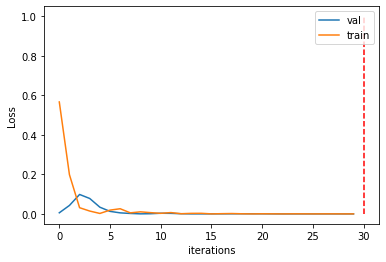

In [ ]:
print(train_loss)
fig, ax = plt.subplots()
ax.plot(val_loss,label="val")
ax.plot(train_loss,label="train")
ax.vlines(30, 0, 1, linestyles='dashed', colors='red')
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.legend()
plt.show()

In [ ]:
lstm_model.eval()
for x_test,y_test in testloader:
  y_test_pred = lstm_model(x_test)
  
print(y_test_pred.shape)


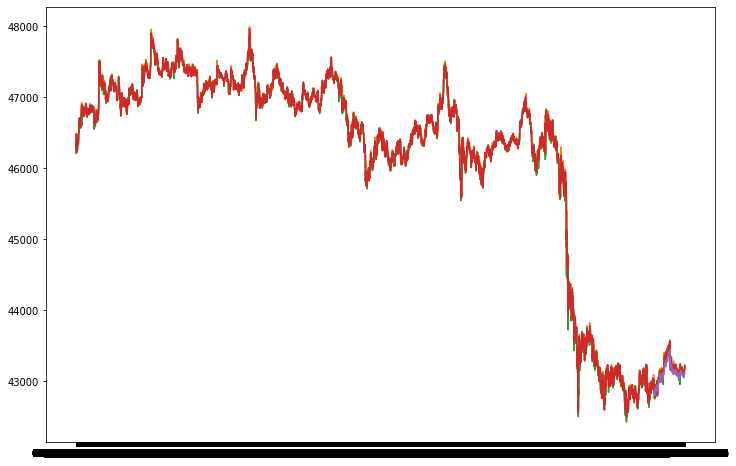

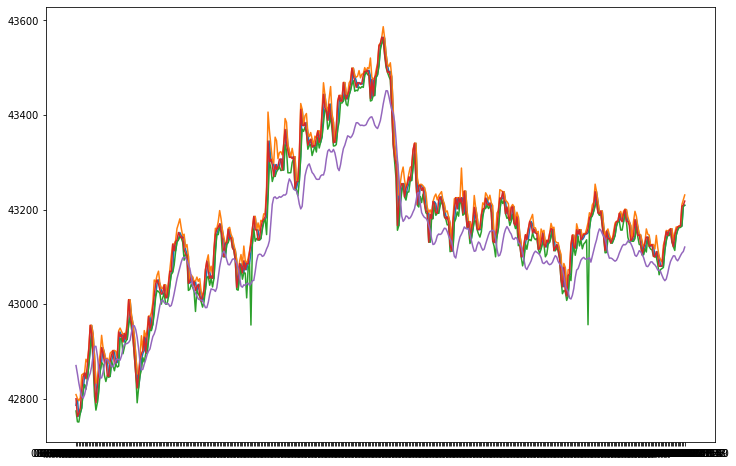

In [ ]:
data_predict = y_test_pred.data.numpy()
data_predict.shape


bi_data_scaler = bi_data['Close']
test_bi_data = np.array(bi_data_scaler)[:, np.newaxis]
descaler = skp.MinMaxScaler()
test_vals_scaled = descaler.fit_transform(test_bi_data)
predictions_rescaled = descaler.inverse_transform(data_predict)


df = pd.DataFrame(predictions_rescaled, index=bi_data.index[8187:])

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bi_data)
ax.plot(df)
plt.show()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bi_data.index[8187:], bi_data.values[8187:])
plt.plot(df)
plt.show()


# test_rescaled = test_bi_data[1840:]

# rmse = skm.mean_squared_error(test_rescaled, predictions_rescaled, squared=False)
# print("Mean squared error for 24 forecast steps:", rmse)
# mape = skm.mean_absolute_percentage_error(test_rescaled, predictions_rescaled)
# print("Mean absolute percentage error for 24 forecast steps:", mape)

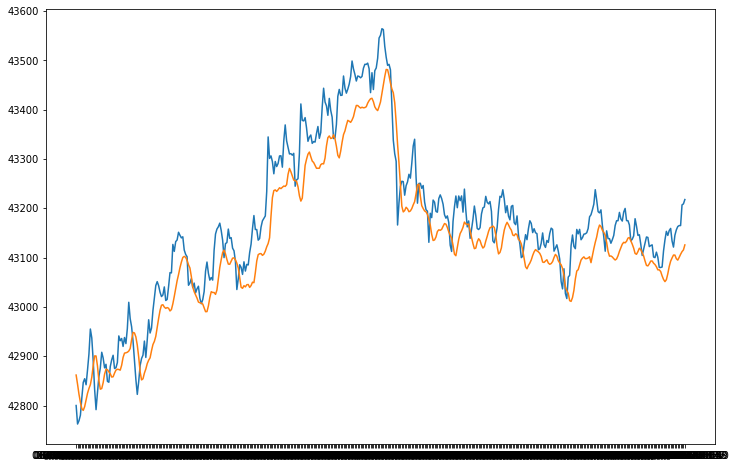

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bi_data['Close'].index[8187:], bi_data['Close'].values[8187:], label="True Close Value")
ax.plot(df, label="Predicted Close Value")
plt.show()